## Import the required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

# To display image
from PIL import Image

# To read dataset images
import cv2
import os

## Inspect the Data


In [2]:
# Check the number of training images
num_images_train_normal = len(os.listdir("../input/chest-xray-pneumonia/chest_xray/train/NORMAL"))
num_images_train_pneumonia = len(os.listdir("../input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA"))

num_images_train_normal, num_images_train_pneumonia

(1341, 3875)

In [3]:
# Getting the class names
import pathlib
import numpy as np
data_dir = pathlib.Path("../input/chest-xray-pneumonia/chest_xray/train/") # turn our training path into a Python path
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
print(class_names)

['NORMAL' 'PNEUMONIA']


**So we've got 1341 images of normal x-rays and 3875 images of pneumonia infected x-rays**

In [4]:
# Function to view an image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

Image shape: (1291, 1654)


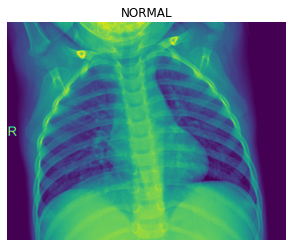

In [5]:
# View a random image from the training dataset
img = view_random_image(target_dir="../input/chest-xray-pneumonia/chest_xray/train/",
                        target_class="NORMAL")

Image shape: (440, 763, 3)


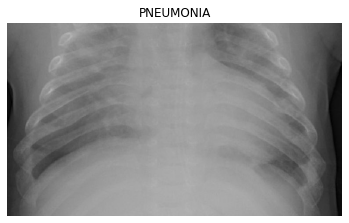

In [6]:
# View a random image from the training dataset
img = view_random_image(target_dir="../input/chest-xray-pneumonia/chest_xray/train/",
                        target_class="PNEUMONIA")

In [7]:
# View the image as an array of pixel values
img

array([[[100, 100, 100],
        [102, 102, 102],
        [103, 103, 103],
        ...,
        [ 59,  59,  59],
        [ 59,  59,  59],
        [ 59,  59,  59]],

       [[100, 100, 100],
        [102, 102, 102],
        [103, 103, 103],
        ...,
        [ 60,  60,  60],
        [ 60,  60,  60],
        [ 60,  60,  60]],

       [[100, 100, 100],
        [102, 102, 102],
        [103, 103, 103],
        ...,
        [ 61,  61,  61],
        [ 61,  61,  61],
        [ 61,  61,  61]],

       ...,

       [[ 41,  41,  41],
        [ 41,  41,  41],
        [ 40,  40,  40],
        ...,
        [ 11,  11,  11],
        [ 11,  11,  11],
        [ 11,  11,  11]],

       [[ 39,  39,  39],
        [ 39,  39,  39],
        [ 38,  38,  38],
        ...,
        [ 11,  11,  11],
        [ 11,  11,  11],
        [ 11,  11,  11]],

       [[ 37,  37,  37],
        [ 37,  37,  37],
        [ 37,  37,  37],
        ...,
        [ 11,  11,  11],
        [ 11,  11,  11],
        [ 11,  11,  11]]

In [8]:
# Normalize the pixel values for img
img/255

array([[[0.39215686, 0.39215686, 0.39215686],
        [0.4       , 0.4       , 0.4       ],
        [0.40392157, 0.40392157, 0.40392157],
        ...,
        [0.23137255, 0.23137255, 0.23137255],
        [0.23137255, 0.23137255, 0.23137255],
        [0.23137255, 0.23137255, 0.23137255]],

       [[0.39215686, 0.39215686, 0.39215686],
        [0.4       , 0.4       , 0.4       ],
        [0.40392157, 0.40392157, 0.40392157],
        ...,
        [0.23529412, 0.23529412, 0.23529412],
        [0.23529412, 0.23529412, 0.23529412],
        [0.23529412, 0.23529412, 0.23529412]],

       [[0.39215686, 0.39215686, 0.39215686],
        [0.4       , 0.4       , 0.4       ],
        [0.40392157, 0.40392157, 0.40392157],
        ...,
        [0.23921569, 0.23921569, 0.23921569],
        [0.23921569, 0.23921569, 0.23921569],
        [0.23921569, 0.23921569, 0.23921569]],

       ...,

       [[0.16078431, 0.16078431, 0.16078431],
        [0.16078431, 0.16078431, 0.16078431],
        [0.15686275, 0

## Preprocessing the data

In [9]:
# Define training,test and validation directory paths
train_dir = "../input/chest-xray-pneumonia/chest_xray/train/"
test_dir = "../input/chest-xray-pneumonia/chest_xray/test/"

In [10]:
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from numpy import expand_dims

In [11]:
train_datagen = ImageDataGenerator(rescale= 1./255)
test_datagen = ImageDataGenerator (rescale=1./255) # for testing, we neever make any modifications, only rescaling can be done

In [12]:
train_set = train_datagen.flow_from_directory(train_dir, target_size=(224,224), batch_size= 32, class_mode='binary')
test_set = test_datagen.flow_from_directory(test_dir, target_size=(224,224), batch_size= 32, class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [13]:
# checking image shape
train_set.image_shape, test_set.image_shape

((224, 224, 3), (224, 224, 3))

In [14]:
# Make the creating of our model a little easier
from keras.models import Sequential
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout, BatchNormalization, ZeroPadding2D #average pooling, global average pooling can be taken as well, 
from keras.optimizers import Adam

In [15]:
# Check lengths of training and test data generators
len(train_set), len(test_set)

(163, 20)

## Creating our improved model (model_1)

In [16]:
# Set random seed
tf.random.set_seed(42)

# Create the model
model_1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=10, kernel_size=(3,3), activation="relu", input_shape=(224,224,3)),
    tf.keras.layers.MaxPool2D(pool_size=2, padding="valid"),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

If convolutional layers learn the features of an image, you can think of a Max Pooling layer as figuring out the most important of those features.

In [17]:
# Compile the model
model_1.compile(loss="binary_crossentropy",
               optimizer=Adam(lr=0.001),
               metrics="accuracy")


In [20]:
# Fit the model
history_1 = model_1.fit(train_set,
                       epochs=5,
                       steps_per_epoch=len(train_set),
                       validation_data=test_set,
                       validation_steps=len(test_set))

Epoch 1/5
163/163 [==============================] - 64s 381ms/step - loss: 0.3779 - accuracy: 0.8242 - val_loss: 0.5944 - val_accuracy: 0.7788
Epoch 2/5
163/163 [==============================] - 57s 351ms/step - loss: 0.0994 - accuracy: 0.9633 - val_loss: 0.6801 - val_accuracy: 0.7676
Epoch 3/5
163/163 [==============================] - 58s 353ms/step - loss: 0.0794 - accuracy: 0.9711 - val_loss: 0.5575 - val_accuracy: 0.8045
Epoch 4/5
163/163 [==============================] - 57s 351ms/step - loss: 0.0693 - accuracy: 0.9731 - val_loss: 1.1486 - val_accuracy: 0.7596
Epoch 5/5
163/163 [==============================] - 57s 350ms/step - loss: 0.0621 - accuracy: 0.9765 - val_loss: 1.0650 - val_accuracy: 0.7804


In [21]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 10)      280       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 10)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 10)      910       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 107, 107, 10)      910       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 105, 105, 10)      910       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 52, 52, 10)        0         
_________________________________________________________________
flatten (Flatten)            (None, 27040)             0

Text(0.5, 1.0, 'Model_1 loss curve')

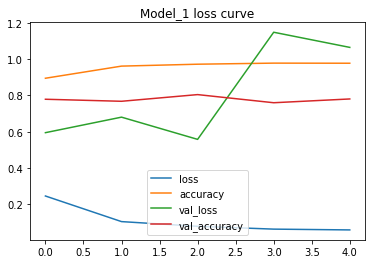

In [22]:
# Plot the loss curves
pd.DataFrame(history_1.history).plot()
plt.title("Model_1 loss curve")

Since the validation loss increased, the model might be overfitting 

In [23]:
# Evaluate the model
model_1.evaluate(test_set)

20/20 [==============================] - 5s 269ms/step - loss: 1.0650 - accuracy: 0.7804


[1.065002202987671, 0.7804487347602844]